In [57]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
import matplotlib.pyplot as plt
import os

In [58]:
from torchvision.datasets import FashionMNIST

In [70]:
SAVE_PATH = "./datasets/"
BATCH_SIZE = 16
EPOCHS = 50
MAX_SANITY_STEPS = 2
IS_TRAINING = False

In [71]:
train_ds = FashionMNIST(SAVE_PATH, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

In [72]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Linear(28 * 28, 2000),
            nn.ReLU(),
            nn.Linear(2000, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
        )
        
    def forward(self, x):
        return self.l1(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Linear(10, 500),
            nn.ReLU(),
            nn.Linear(500, 2000),
            nn.ReLU(),
            nn.Linear(2000, 784),
        )
    def forward(self, x):
        return self.l1(x)

In [104]:
class FashionMNISTAutoEncoder(LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder 
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        x_1 = self.encoder(x)
        x_pred = self.decoder(x_1)
        loss = F.mse_loss(x, x_pred)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, _ = batch
        print(batch_idx)
        if(batch_idx == 0):
            index_test = 0            

            x_original_img = x.cpu()
            plt.title("Original Image")
            plt.imshow(x_original_img[index_test][0])
            plt.show()

            x_test_batch = x.view(x.size(0), -1)
            x_1 = self.encoder(x_test_batch)
            x_pred = self.decoder(x_1)
            loss = F.mse_loss(x_pred, x_test_batch)

            x_pred_img = x_pred[index_test].reshape(28, -1)
            x_pred_img = x_pred_img.cpu()
            plt.title("Predicted Image")
            plt.imshow(x_pred_img)
            plt.show()
            self.log("test_loss", loss)
            
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [105]:
autoencoder = FashionMNISTAutoEncoder(Encoder(), Decoder())
trainer = Trainer(accelerator="auto", devices=1 if torch.cuda.is_available() else None, max_epochs=EPOCHS, num_sanity_val_steps=MAX_SANITY_STEPS)
if(IS_TRAINING):
    trainer.fit(model=autoencoder, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<h2>Testing</h2>

Restoring states from the checkpoint path at ./lightning_logs/version_6/checkpoints/epoch=49-step=187500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/version_6/checkpoints/epoch=49-step=187500.ckpt
c:\Users\steve\anaconda3\envs\pytorchMain\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

0


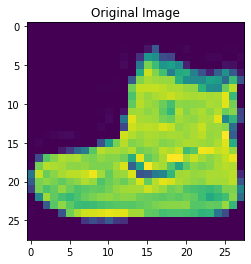

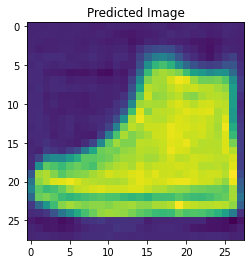

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


c:\Users\steve\anaconda3\envs\pytorchMain\lib\site-packages\pytorch_lightning\trainer\trainer.py:657: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [106]:
trainer.test(model=autoencoder, ckpt_path="./lightning_logs/version_6/checkpoints/epoch=49-step=187500.ckpt", dataloaders=train_loader)